## Name: Shail K Shah
## USC ID: 9975958845
## GitHub username: anonshail

### All Imports

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, scale
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_squared_error
import re
import math
from sklearn.linear_model import RidgeCV, LinearRegression, LassoCV
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import xgboost as xgbT
xgbT.set_config(verbosity=0)


### 1. Decision Trees as Interpretable Models
### 1.a. Download the Accute Inflamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations
### 1.b. Build a decision tree on the whole data set and plot it.


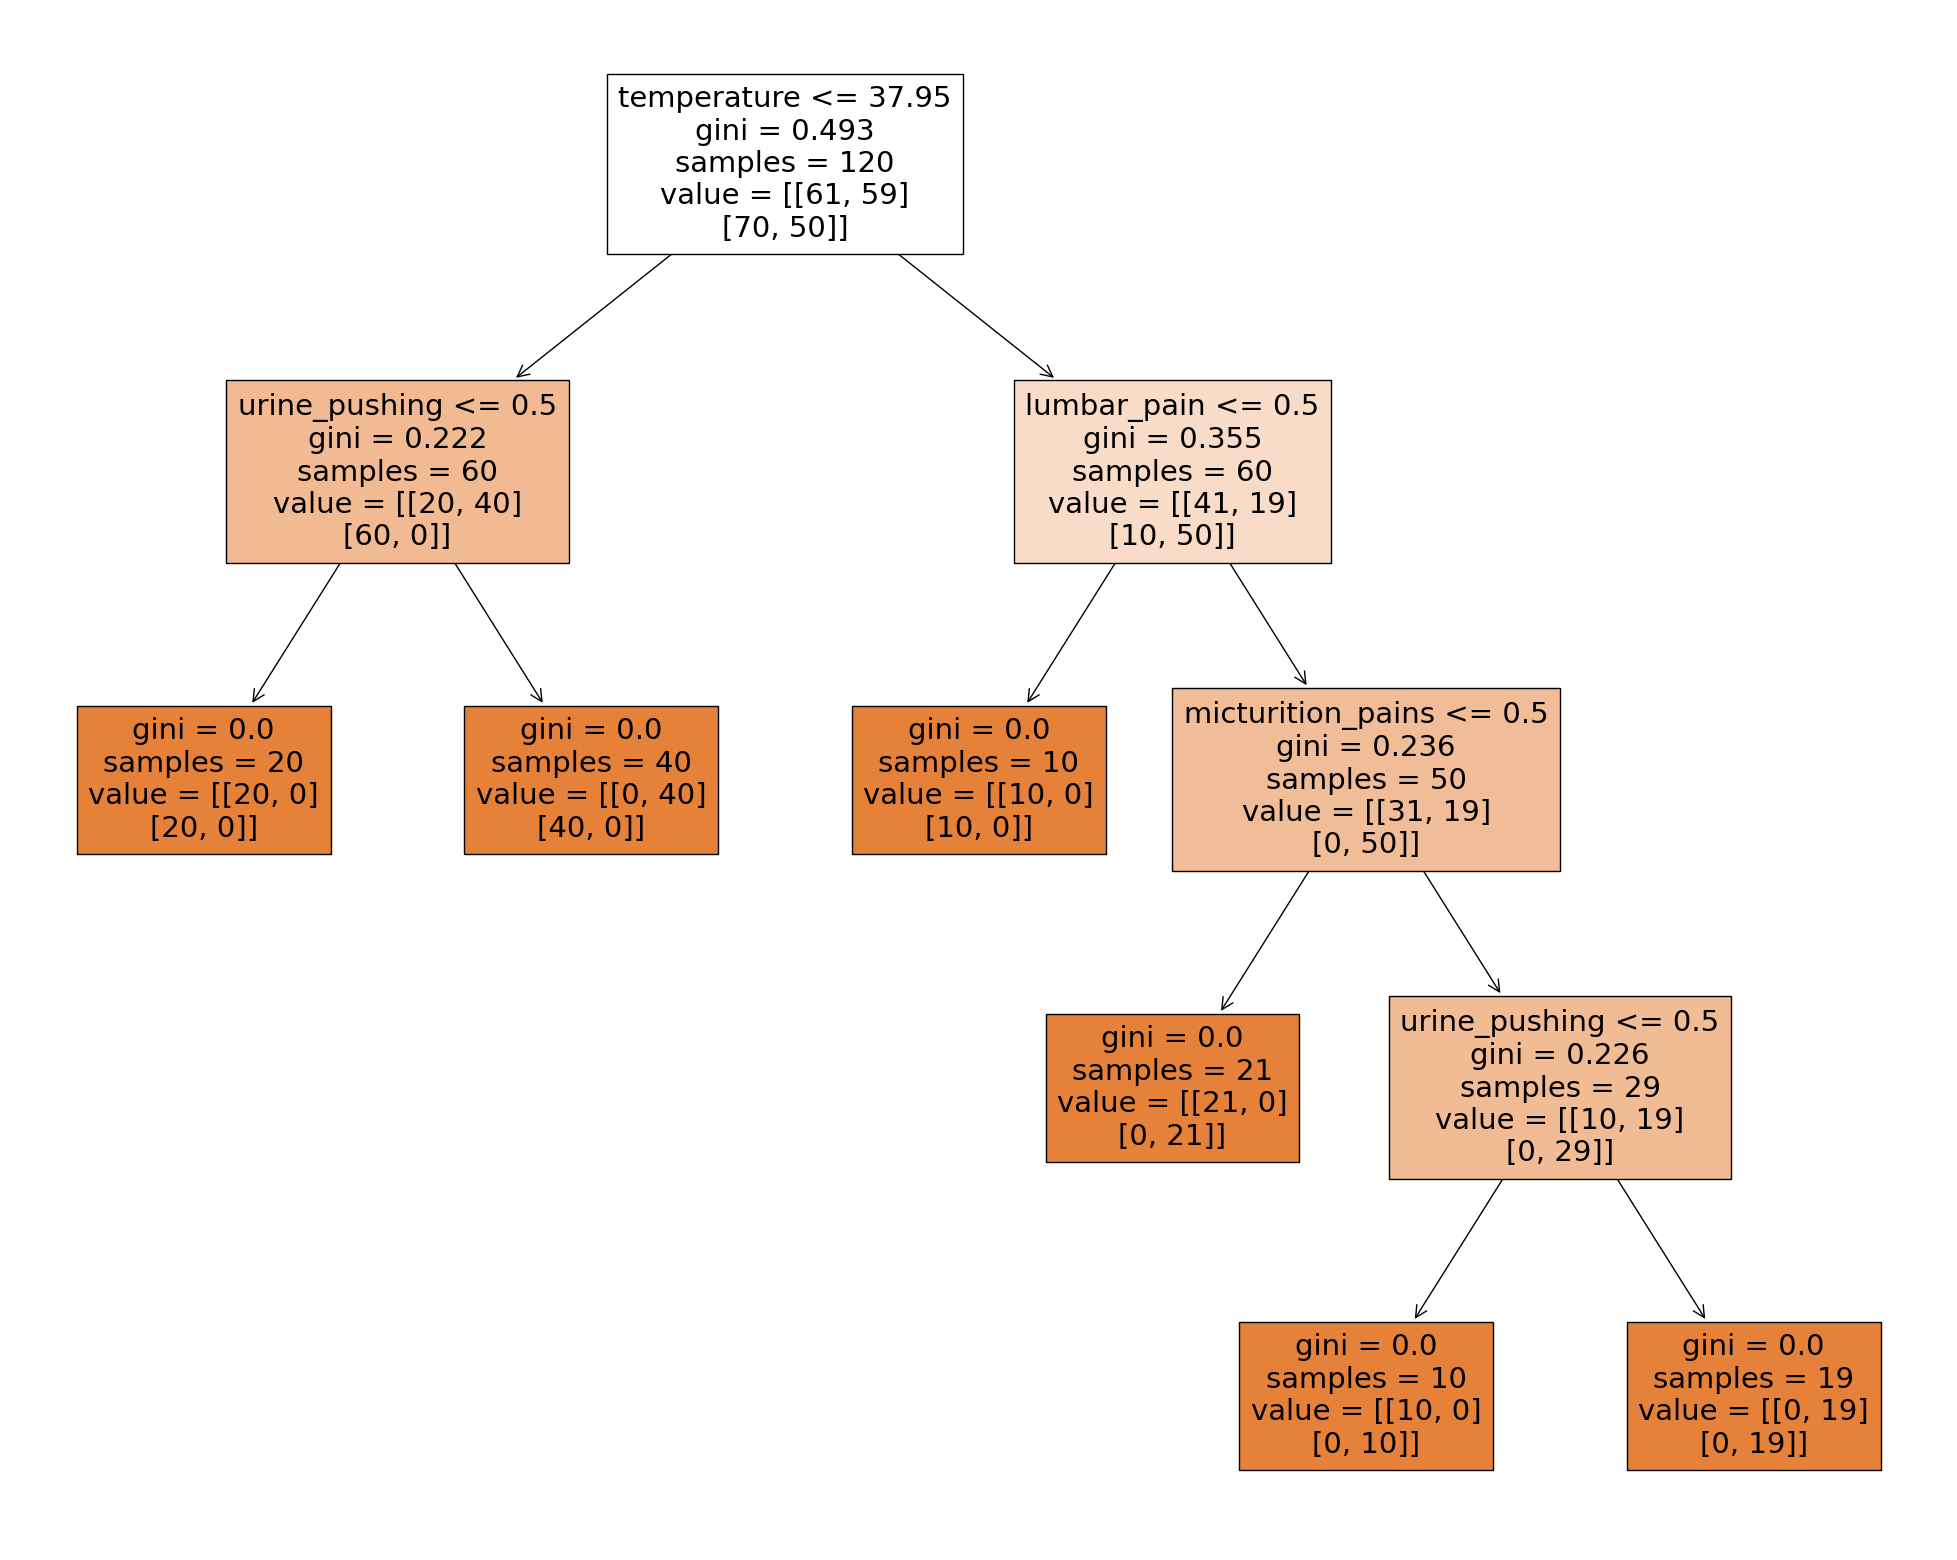

In [2]:
cols = ['temperature', 'nausea', 'lumbar_pain', 'urine_pushing', 'micturition_pains', 'urethra_issues', 'urinary_bladder_inflamation', 'renal_pelvis_nephritis']
data = pd.read_csv('../data/diagnosis.data', sep = '\t', encoding='utf-16', names = cols)

data['temperature'] = data['temperature'].apply(lambda record: record.replace(',','.'))
for column in data.columns.values:
    if column != 'temperature':
        data[column] = data[column].map(dict(yes=1, no=0))

X = data.iloc[:,0:6]
y = data.iloc[:, 6:]
X

decisionTree = DecisionTreeClassifier()
decisionTree.fit(X, y)

fig = plt.figure(figsize=(25,20))
_ = plot_tree(decisionTree, feature_names=cols, class_names=y.columns.values, filled=True)

### 1.c Convert the decision rules into a set of IF-THEN rules.

In [3]:
def tree_to_code(tree, feature_names):
	"""
	Outputs a decision tree model as a Python function
	
	Parameters:
	-----------
	tree: decision tree model
		The decision tree to represent as a function
	feature_names: list
		The feature names of the dataset used for building the decision tree
	"""

	tree_ = tree.tree_
	feature_name = [
		feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
		for i in tree_.feature
	]
	print("def tree({}):".format(", ".join(feature_names)))

	def recurse(node, depth):
		indent = "  " * depth
		if tree_.feature[node] != _tree.TREE_UNDEFINED:
			name = feature_name[node]
			threshold = tree_.threshold[node]
			print("{}if {} <= {}:".format(indent, name, threshold))
			recurse(tree_.children_left[node], depth + 1)
			print("{}else:  # if {} > {}".format(indent, name, threshold))
			recurse(tree_.children_right[node], depth + 1)
		else:
			print("{}return {}".format(indent, tree_.value[node]))

	recurse(0, 1)

tree_to_code(decisionTree, data.columns.values)

def tree(temperature, nausea, lumbar_pain, urine_pushing, micturition_pains, urethra_issues, urinary_bladder_inflamation, renal_pelvis_nephritis):
  if temperature <= 37.95000076293945:
    if urine_pushing <= 0.5:
      return [[20.  0.]
 [20.  0.]]
    else:  # if urine_pushing > 0.5
      return [[ 0. 40.]
 [40.  0.]]
  else:  # if temperature > 37.95000076293945
    if lumbar_pain <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if lumbar_pain > 0.5
      if micturition_pains <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else:  # if micturition_pains > 0.5
        if urine_pushing <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else:  # if urine_pushing > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]


### 1.d Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

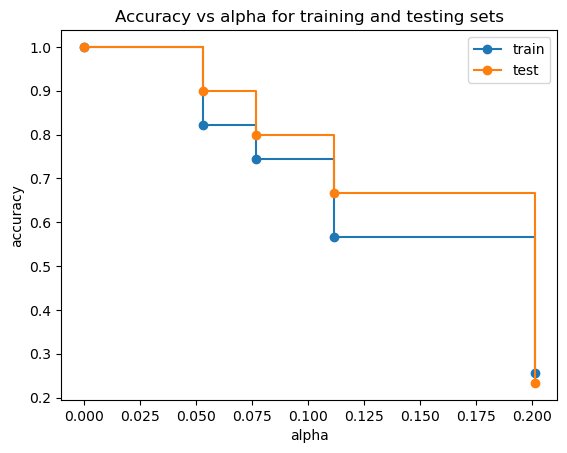

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()



From the above graph, it is clear that the best decision tree with alpha = 0. This means that the original tree (with no pruning) has the highest accuracy.

To find a minimal decision tree and a set of decision rules with high interpretability, we would pick the tree with the highest accuraacy with alpha > 0. In this, the following would be the decision tree and the decision rules.

Alpha value of pruned tree:  0.05333333333333333
def tree(temperature, nausea, lumbar_pain, urine_pushing, micturition_pains, urethra_issues, urinary_bladder_inflamation, renal_pelvis_nephritis):
  if temperature <= 37.95000076293945:
    if urine_pushing <= 0.5:
      return [[16.  0.]
 [16.  0.]]
    else:  # if urine_pushing > 0.5
      return [[ 0. 27.]
 [27.  0.]]
  else:  # if temperature > 37.95000076293945
    if lumbar_pain <= 0.5:
      return [[7. 0.]
 [7. 0.]]
    else:  # if lumbar_pain > 0.5
      return [[24. 16.]
 [ 0. 40.]]


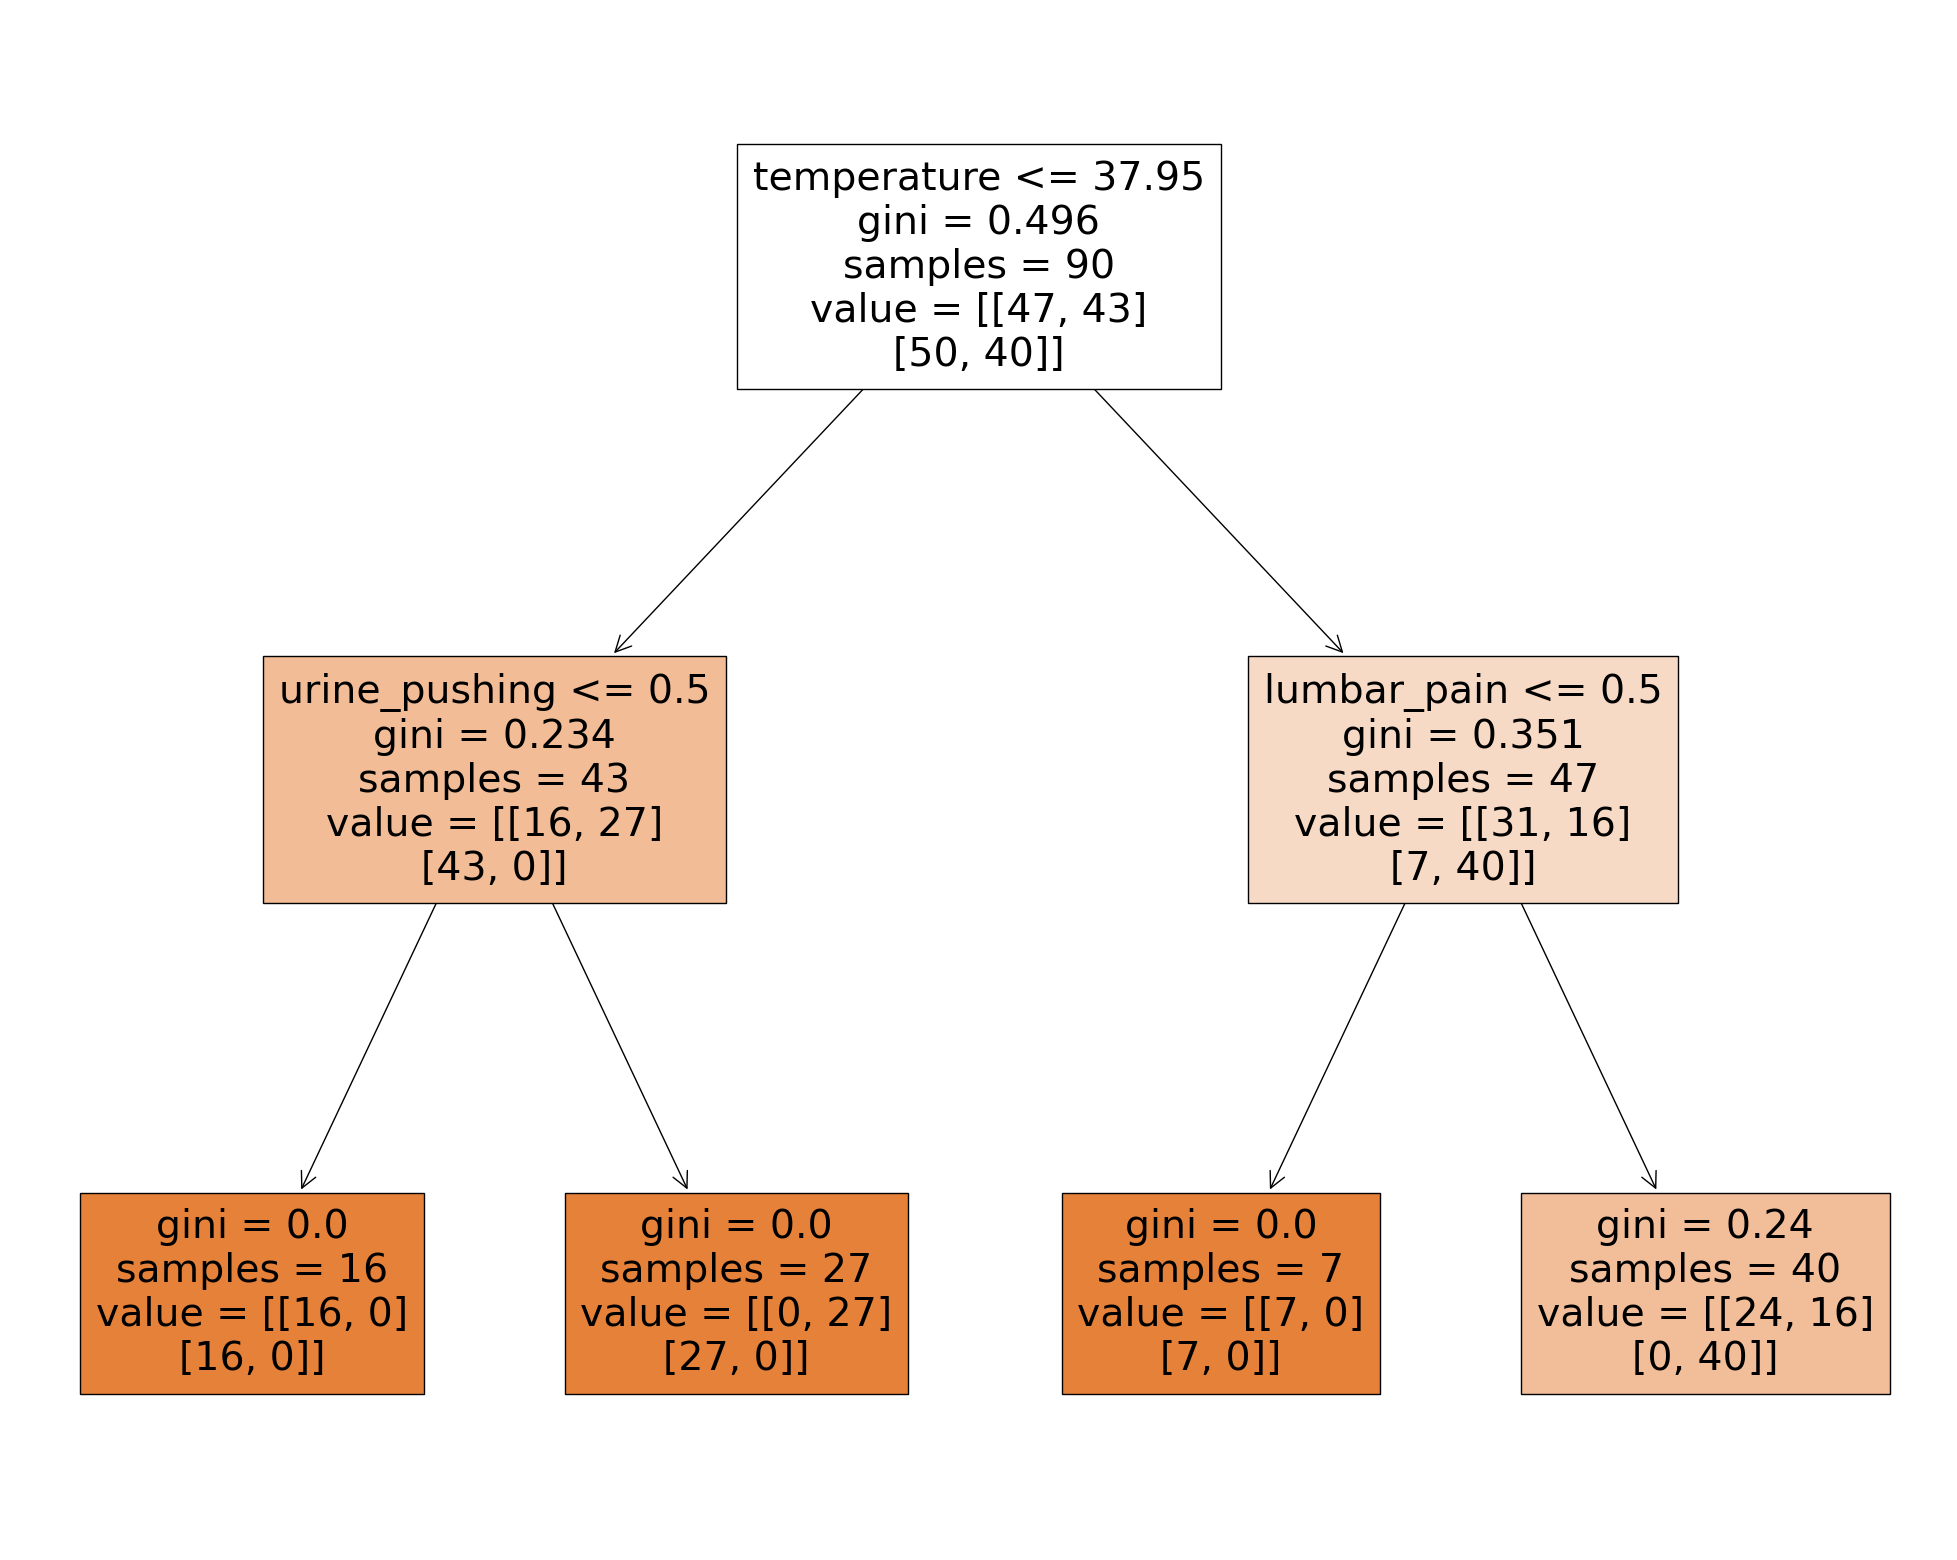

In [5]:
print("Alpha value of pruned tree: ", ccp_alphas[1])

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clfs[1], feature_names=cols, class_names=y.columns.values, filled=True)

tree_to_code(clfs[1], data.columns.values)


### 2. The LASSO and Boosting for Regression

### 2.a Download the Communities and Crime data 3 from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.

In [6]:
file = open('../data/communities.names','r')
result = re.findall('@attribute (.*) ', file.read())
dropCols = ['state','county','community', 'communityname', 'fold']
data = pd.read_csv("../data/communities.data", names = result, na_values=['?'])
data = data.drop(dropCols, axis = 1)
data_train = data.iloc[:1495]
data_test = data.iloc[1495:]

print(data_train)
print(data_test)

      population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0           0.19           0.33          0.02          0.90          0.12   
1           0.00           0.16          0.12          0.74          0.45   
2           0.00           0.42          0.49          0.56          0.17   
3           0.04           0.77          1.00          0.08          0.12   
4           0.01           0.55          0.02          0.95          0.09   
...          ...            ...           ...           ...           ...   
1490        0.00           0.59          0.01          0.69          1.00   
1491        0.16           0.62          0.03          0.74          0.48   
1492        0.01           0.36          0.95          0.24          0.03   
1493        0.06           0.53          0.01          0.98          0.05   
1494        0.05           0.43          0.08          0.65          0.12   

      racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  

### 2.b The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [7]:
data = data.fillna(data.mean())
data_train = data.iloc[:1495]
data_test = data.iloc[1495:]

print(data_train)
print(data_test)

      population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0           0.19           0.33          0.02          0.90          0.12   
1           0.00           0.16          0.12          0.74          0.45   
2           0.00           0.42          0.49          0.56          0.17   
3           0.04           0.77          1.00          0.08          0.12   
4           0.01           0.55          0.02          0.95          0.09   
...          ...            ...           ...           ...           ...   
1490        0.00           0.59          0.01          0.69          1.00   
1491        0.16           0.62          0.03          0.74          0.48   
1492        0.01           0.36          0.95          0.24          0.03   
1493        0.06           0.53          0.01          0.98          0.05   
1494        0.05           0.43          0.08          0.65          0.12   

      racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  

### 2.c Plot a correlation matrix for the features in the data set.

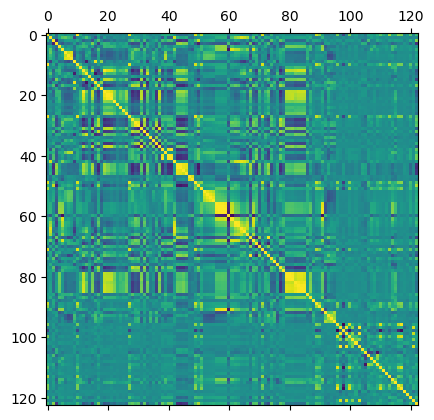

In [8]:
plt.matshow(data.corr())

### 2.d Calculate the Coecient of Variation CV for each feature, where CV = s/m, in which s is sample variance and m is sample mean..

In [9]:
cv = [np.std(data[x]) / np.mean(data[x]) for x in data]
cv

[2.2029499338653187,
 0.35320970041190364,
 1.4105665605340405,
 0.32370036336013336,
 1.3588213380942586,
 1.613872957148404,
 0.36574812216271013,
 0.290619987380047,
 0.4950363361780553,
 0.42333551661050045,
 2.001241633513718,
 0.6386886583257838,
 0.5796080008727301,
 0.327627874264053,
 0.6998545594658843,
 0.35914985569917485,
 0.3684202133633651,
 0.6988551987450087,
 0.3495513990736712,
 0.5275995387856802,
 0.5454965924474837,
 0.5074249049035474,
 0.5893211744649149,
 0.8094820310422658,
 0.6060418273404299,
 0.6704763858174286,
 0.4738408572341722,
 2.304391666011784,
 0.7537910884956593,
 0.6754307871530835,
 0.5281537809121716,
 0.5782557850622498,
 0.5559933294527711,
 0.34724014147772386,
 0.5104522961225946,
 0.3981258072393741,
 0.5083337971819726,
 0.4219999986300119,
 0.3954841631402557,
 0.4037103467775632,
 0.35918260394972323,
 0.37137499520300693,
 0.31687526059726756,
 0.33052822510497293,
 0.3323925011805811,
 0.32934322729395377,
 0.32846855204578795,
 0.336

### 2.e Pick √128 features with highest CV, and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?


Coeficients of all Coloumns:

                       0         1
90             NumStreet  4.406597
89         NumInShelters  3.484607
49              NumIlleg  2.993446
51              NumImmig   2.89977
120  LemasPctOfficDrugUn  2.554625
..                   ...       ...
111    NumKindsDrugsSeiz  0.145919
104   RacialMatchCommPol  0.131384
118  LemasPctPolicOnPatr  0.122301
105        PctPolicWhite  0.121629
98     LemasSwFTFieldOps  0.057112

[122 rows x 2 columns]


Selected Coloumns:

                       0         1
90             NumStreet  4.406597
89         NumInShelters  3.484607
49              NumIlleg  2.993446
51              NumImmig   2.89977
120  LemasPctOfficDrugUn  2.554625
27           NumUnderPov  2.304392
10             numbUrban  2.001242
71            HousVacant  1.958288
113             LandArea  1.677611
5            racePctHisp  1.613873
61   PctNotSpeakEnglWell  1.458701


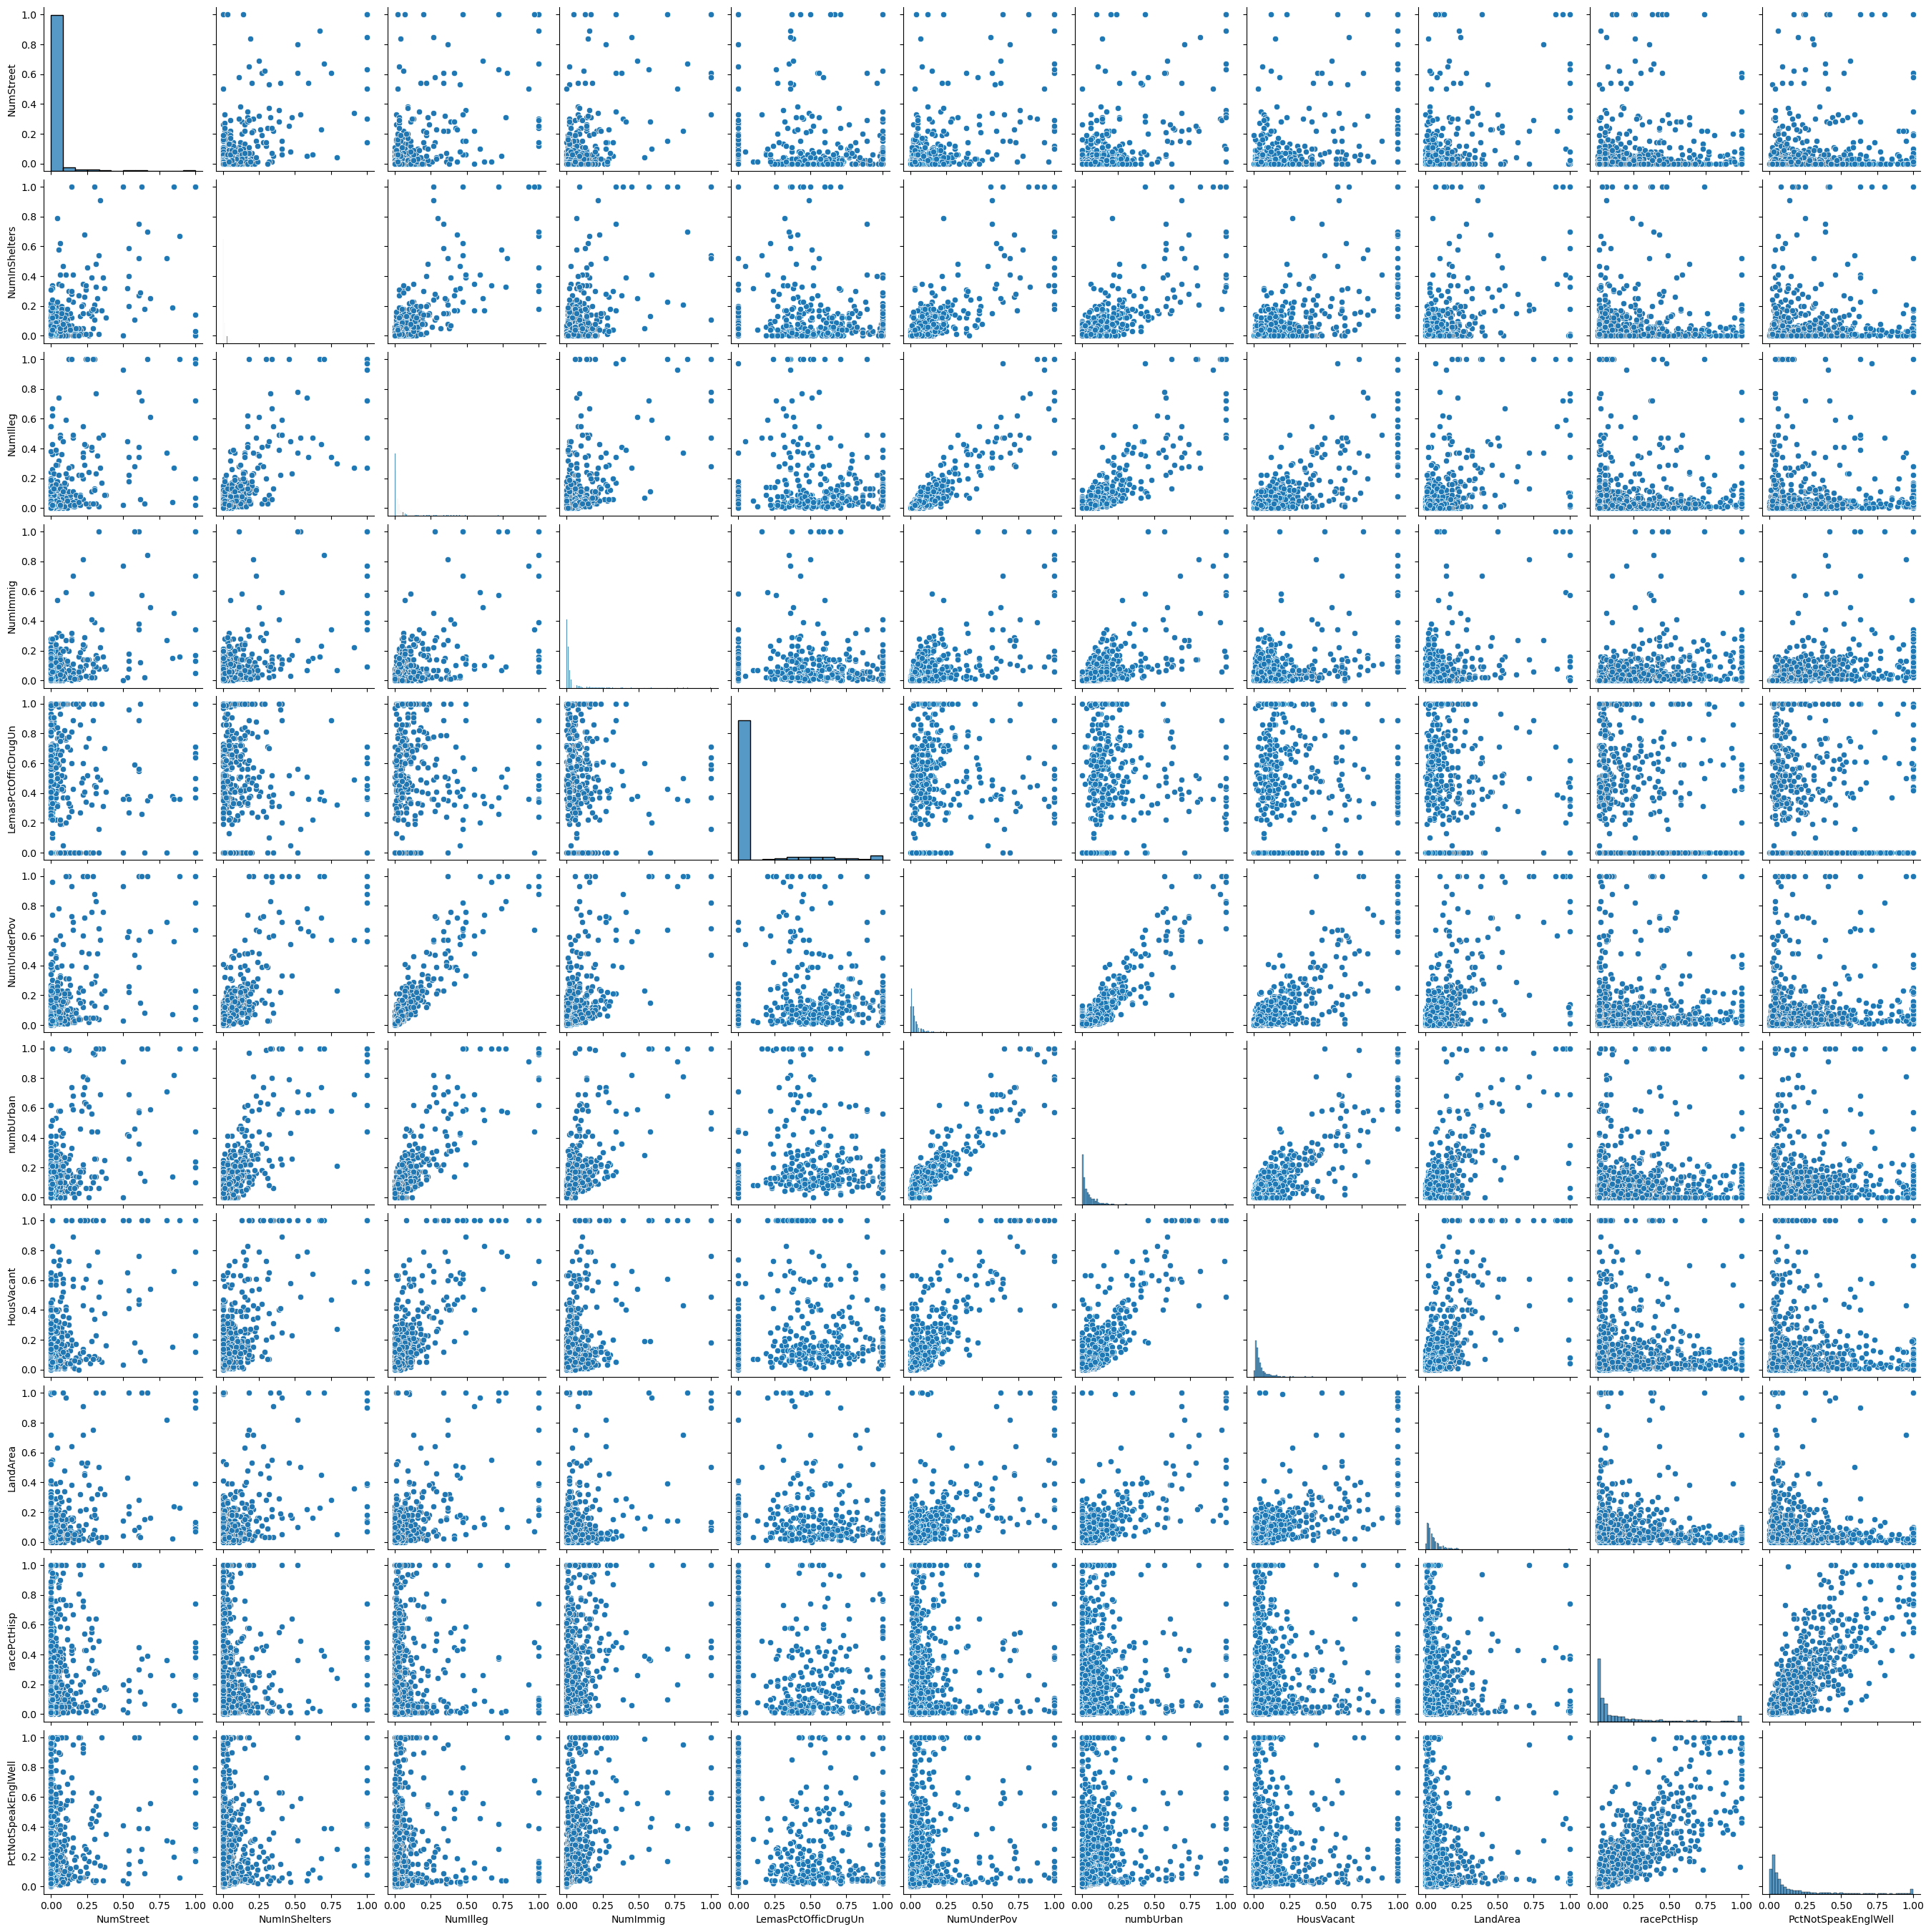

In [10]:
cv = np.apply_along_axis(lambda x: np.std(x) / np.mean(x), axis=0, arr=data.values)
cols=data.columns.values
colvar=pd.DataFrame(np.column_stack([cols, cv]))

# Dropping the id coloumn
colvar=colvar.drop(0)
# colvar.columns = ['Feature', 'Coefficient']

#sorting
sortedValues = colvar.sort_values(1, ascending=False)
print("\nCoeficients of all Coloumns:\n")
print(sortedValues)

#filtering according to giving requirements
x = sortedValues.head(int(math.floor(math.sqrt(128))))
selectedColumns = data[x[0]]
print("\n\nSelected Coloumns:\n")
print(x)
sns.pairplot(selectedColumns)
plt.show()

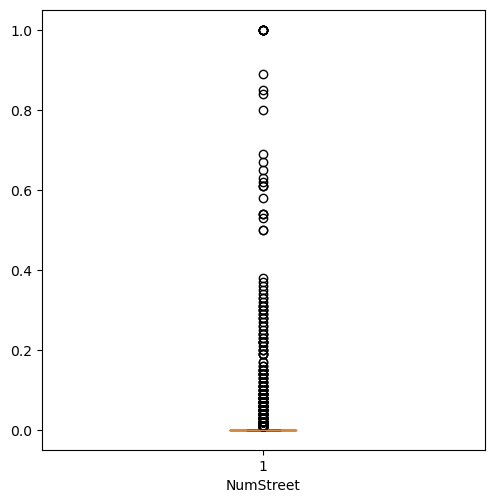

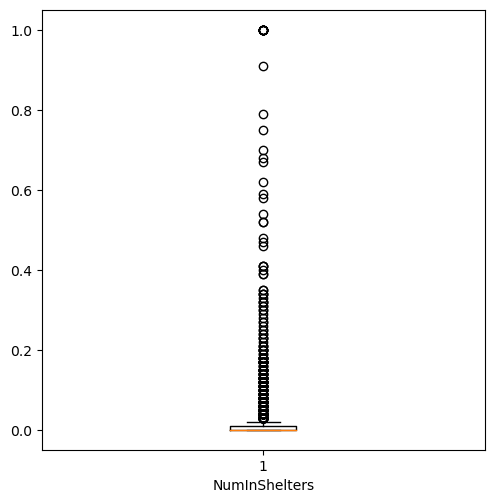

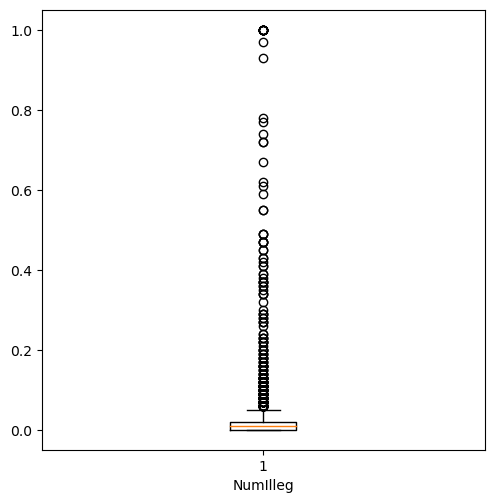

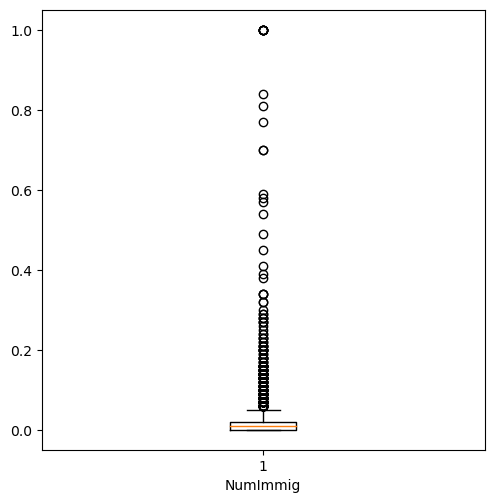

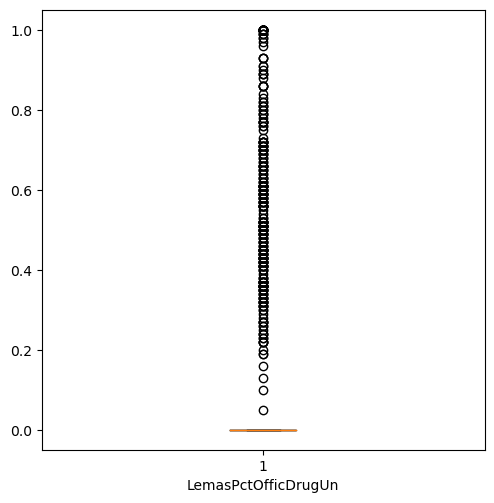

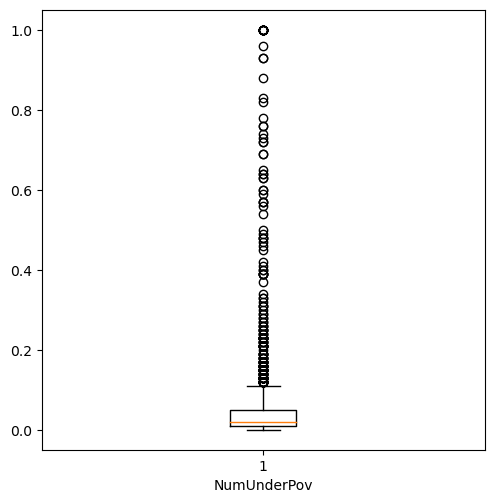

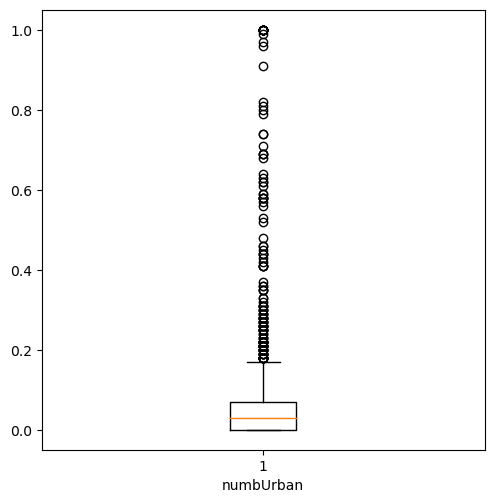

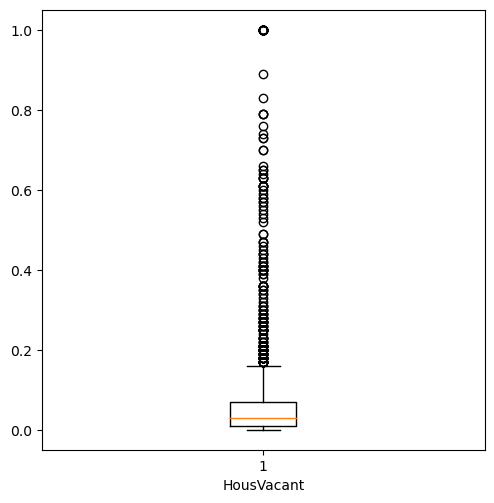

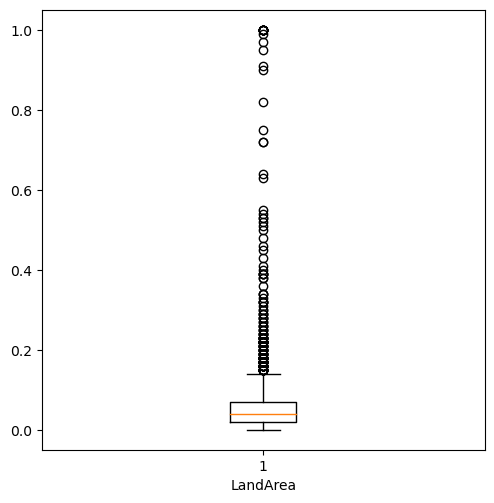

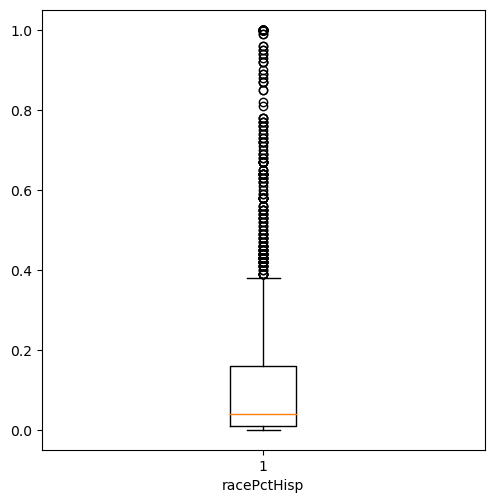

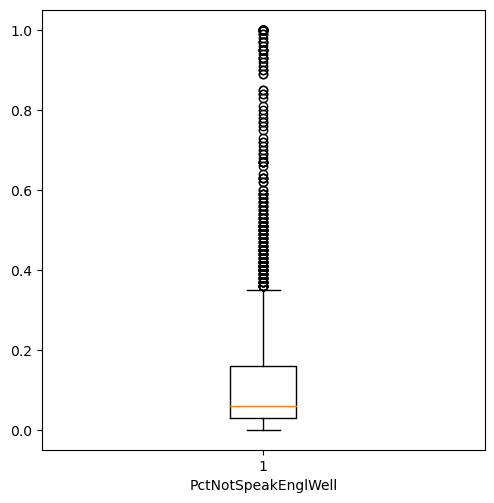

In [11]:
i=0
for col in selectedColumns.columns:
    i+=1
    plt.subplots(figsize=(40, 40))
    plt.subplot(6,6,i)
    plt.xlabel(col)
    plt.boxplot(selectedColumns[col])

### 2.f Fit a linear model using least squares to the training set and report the test error.

In [12]:
#x, y split from train and test
data_train_x = data_train.iloc[:,:122]
data_test_x = data_test.iloc[:,:122]
data_train_y = data_train.iloc[:,122:123] 
data_test_y = data_test.iloc[:,122:123] 

#training model and calculating error
r = LinearRegression()
fr =  r.fit(data_train_x, data_train_y)
y_pred = fr.predict(data_test_x)
mse = mean_squared_error(y_pred,data_test_y)
print("MSE: ", mse)

MSE:  0.7897255274361294


### 2.g Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [13]:
alphas = np.linspace(1e-3, 10, 10000)
clf = RidgeCV(alphas = alphas).fit(data_train_x, data_train_y)
scal_pred_ridge = clf.predict(data_train_x)

# for test Error
print("λ value having minimum error: ",clf.alpha_)

clf = RidgeCV(alphas=alphas).fit(data_train_x, data_train_y)
pred_ridge= clf.predict(data_test_x)
mse_ridge=mean_squared_error(data_test_y,pred_ridge)

print("Ridge Regression Test Error: ",mse_ridge)

λ value having minimum error:  2.256
Ridge Regression Test Error:  0.01760665250666522


### 2.h Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized 4 features. Report the test error for both cases and compare them.

In [14]:
regression = LassoCV(tol=0.001).fit(data_train_x,data_train_y.values.ravel())
regression.score(data_test_x,data_test_y)
variables=regression.coef_
pred_lasso= regression.predict(data_test_x)
mse_lasso=mean_squared_error(data_test_y,pred_lasso)
print("Test Error for Lasso Regression: ",mse_lasso)

finAns = []

for i, x in enumerate(data):
    if(i<122 and variables[i]!=0):
        finAns.append([x, variables[i]])

finAns = pd.DataFrame.from_dict(finAns)
finAns.columns = ['Feature Name', 'Coefficient']
finAns

Test Error for Lasso Regression:  0.01773619542170314


,Feature Name,Coefficient
0,racepctblack,0.270388
1,racePctAsian,-0.013881
2,agePct12t21,0.059939
3,agePct12t29,-0.250959
4,pctUrban,0.040315
...,...,...
70,PctUsePubTrans,-0.042312
71,LemasPctPolicOnPatr,0.024595
72,LemasGangUnitDeploy,0.040266
73,LemasPctOfficDrugUn,0.002790


In [15]:
filteredFeatures = finAns['Feature Name']

# Normalized Features
scaled = pd.DataFrame(scale(data))

#train test split
scaled_data_train = scaled.iloc[0:1495,]
scaled_data_test= scaled.iloc[1496:,]
scaled_train_x = scaled_data_train.iloc[:,:122]
scaled_test_x = scaled_data_test.iloc[:,:122]
scaled_train_y = scaled_data_train.iloc[:,122:123] 
scaled_test_y = scaled_data_test.iloc[:,122:123]

#filtering
filt_train_lasso_x = scaled_train_x[filteredFeatures.index]
filt_test_lasso_x = scaled_test_x[filteredFeatures.index]

#regression
regression_filt = LassoCV(tol=0.001).fit(filt_train_lasso_x,scaled_train_y.values.ravel())
scale_pred_lasso_filt = regression_filt.predict(filt_test_lasso_x)
mse_lasso_filt = mean_squared_error(scaled_test_y,scale_pred_lasso_filt)

print("Test Error with normalized features: ",mse_lasso_filt)

Test Error with normalized features:  0.32718362569080206


### 2.i Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [16]:
global_mse = []
minM = 1

for posM in range(1, 123, 1):
    kf = KFold()
    MSE = []
    
    pca = PCA(n_components=posM)
    x_pca = pca.fit_transform(data_train_x)
    
    for train_index,val_index in kf.split(x_pca):
        x_train = x_pca[list(train_index)]
        x_val = x_pca[list(val_index)]
        y_train = np.array(data_train_y)[list(train_index)]
        y_val = np.array(data_train_y)[list(val_index)]
        model = LinearRegression()
        model = model.fit(x_train,y_train)
        pred = model.predict(x_val)
        mse = mean_squared_error(y_val, pred)
        MSE.append(mse)
        
    calcMSE = np.mean(MSE)
    global_mse.append(calcMSE)
        
    if(calcMSE < global_mse[minM-1]):
        minM = posM
        
print('M Value chosen by cross-validation: ', minM)

pca = PCA(n_components = minM)
x_pca_train = pca.fit_transform(data_train_x)
x_pca_test = pca.fit_transform(data_test_x)

Y_train = np.array(data_train_y)
Y_test = np.array(data_test_y)

model = LinearRegression()
model = model.fit(x_pca_train,Y_train)
pred = model.predict(x_pca_test)

mse = mean_squared_error(Y_test, pred)

print(f"Test set error for M = {minM} components: ",mse)

M Value chosen by cross-validation:  96
Test set error for M = 96 components:  0.02899338978740636


### 2.j In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation.

In [17]:
# for the following range of values 
lambdas = np.linspace(1e-2, 10, 50)


l1_mse = []

for l in lambdas:
    MSE = []
    kf = KFold()
    for train_index,val_index in kf.split(data_train_x):
        x_train = data_train_x.iloc[train_index.tolist(),:]
        x_val = data_train_x.iloc[val_index.tolist(),:]
        y_train = np.array(data_train_y)[list(train_index)]
        y_val = np.array(data_train_y)[list(val_index)]
        xgb = XGBRegressor(random_state=0,reg_alpha=l)
        xgb.fit(x_train,y_train)
        pred = xgb.predict(x_val)
        mse = mean_squared_error(y_val, pred)
        MSE.append(mse)
    l1_mse.append((np.mean(MSE), l))
    
alpha = min(l1_mse)[1]

print('Chosen α value: ', alpha)

l1_mse = [x[0] for x in l1_mse]    
xgb = XGBRegressor(random_state=0,reg_alpha=alpha)
xgb.fit(data_train_x,data_train_y)
pred = xgb.predict(data_test_x)
L1_2_mse = mean_squared_error(data_test_y, pred)

print("L1 Regularization MSE",L1_2_mse)

Chosen α value:  3.4759183673469387
L1 Regularization MSE 0.017529612348418197
